# Movie Recommendation System

By: Anat Jacobson and Stephanie Ciaccia 

---

## Overview

Our team is currently developing a movie recommendation model that utilizes review data obtained from MovieLens. The goal of the model is to provide personalized movie recommendations to users based on their ratings of other movies.

The MovieLens dataset is a well-established resource in the field of recommendation systems, and has been used in various academic studies and machine learning experiments. To tailor the app to individual users, we will design a system for users to provide their own ratings of movies. This will help the app suggest movies that align with their preferences.

# Business Problem

For many movie enthusiasts, it can be a real challenge to find a film to watch when they don't have a specific genre or title in mind. Sifting through endless options online can be a frustrating and time-consuming experience.

To tackle this issue, we're developing a recommendation model that will be rolled out as part of an app. This tool will gather data on the user's previously watched and rated films, and then suggest movies that they haven't seen yet based on predicted ratings.

Our goal is to provide a seamless and personalized movie selection experience, reducing the time and effort required for users to find something they'll enjoy.

# Data

### Source : Grouplens
The data used in our analysis was obtained from [Movie Lens]([http://movielens.org]), which consists of user ratings on movies using a 5-star scale. The dataset was collected between March 29, 1996, and September 24, 2018, and includes ratings from 610 users. In total, the dataset contains 100836 ratings and 3683 tags across 9742 movies.

Files from the dataset inclue `links.csv`, `movies.csv`, `ratings.csv` and `tags.csv`.

## Data Exploration and Analysis

Importing all packages needed for the analysis and creating a function for printing long lists

In [204]:
import pandas as pd
import numpy as np
import math
from datetime import datetime
import datetime

import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
%matplotlib inline
import plotly
import plotly.express as px
from matplotlib.ticker import StrMethodFormatter

from surprise.model_selection import cross_validate
from surprise import Dataset, Reader, accuracy
from surprise.prediction_algorithms import KNNWithMeans, KNNBasic, KNNBaseline,  SVD, SVDpp, NMF, BaselineOnly, NormalPredictor
from surprise.model_selection import GridSearchCV, cross_validate, train_test_split
import numpy as np

from collections import Counter
from nltk.corpus import stopwords

import pandas as pd
from IPython.display import display


Function for printing long lists

In [3]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

### Import CSVs, Merge, and Clean all Data Needed
#### 4 Datasets imported:

- Movies: contains all movie ids, titles and genre information
- Links: contains movie ids, imdb id, and tmdb id
- Ratings: contains user id, movie id, ratings per user of movie, and timing of the rating
- Tags: contains user id, movie id, specific tag the user has given it, and the timing of the tag

In [150]:
#importing datasets
ratings_df = pd.read_csv("data/ratings.csv")
movies_df = pd.read_csv("data/movies.csv")
links_df = pd.read_csv("data/links.csv")
tags_df = pd.read_csv("data/tags.csv")

In [151]:
#checking the shape of all dfs
print('movies_df: ', movies_df.shape)
print('links_df: ',links_df.shape)
print('ratings_df: ',ratings_df.shape)
print('tags_df: ',tags_df.shape)

movies_df:  (9742, 3)
links_df:  (9742, 3)
ratings_df:  (100836, 4)
tags_df:  (3683, 4)


In [152]:
#displaying the first 5 rows of each data frames
display(movies_df.head())
display(links_df.head())
display(ratings_df.head())
display(tags_df.head())

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


,userId,movieId,tag,timestamp
0,2,60756,funny,1445714994
1,2,60756,Highly quotable,1445714996
2,2,60756,will ferrell,1445714992
3,2,89774,Boxing story,1445715207
4,2,89774,MMA,1445715200


In [153]:
tag_group_df = tags_df.groupby(by="movieId").agg({"tag":" ".join})

In [154]:
#we would want to run a vectorizer and clean data
tag_group_df.value_counts()

tag                                                               
In Netflix queue                                                      109
Disney                                                                 15
aliens                                                                 10
Shakespeare                                                            10
Stephen King                                                            9
                                                                     ... 
death penalty Nun                                                       1
death penalty John Grisham                                              1
deafness                                                                1
darth vader luke skywalker space opera                                  1
"artsy" atmospheric gritty hallucinatory surreal visually stunning      1
Length: 1038, dtype: int64

### Inspecting ratings


In [155]:
ratings_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [156]:
ratings_df.userId.value_counts()

414    2698
599    2478
474    2108
448    1864
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: userId, Length: 610, dtype: int64

### Inspecting movies

In [157]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genres   9742 non-null   object
dtypes: int64(1), object(2)
memory usage: 228.5+ KB


In [158]:
#splitting genre into multiple columns
genre_split = pd.DataFrame(movies_df.genres.str.split('|',6).tolist(),
                                 columns = ['genre_1','genre_2', 'genre_3',
                                            'genre_4', 'genre_5', 'genre_6', 'genre_7'])

#merging dataframes
movies_df = pd.merge(pd.DataFrame(movies_df), pd.DataFrame(genre_split), left_index=True, right_index=True)

#dropping genre columns
movies_df.drop(columns="genres", inplace=True)

In [159]:
genre_split

,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7
0,Adventure,Animation,Children,Comedy,Fantasy,None,None
1,Adventure,Children,Fantasy,None,None,None,None
2,Comedy,Romance,None,None,None,None,None
3,Comedy,Drama,Romance,None,None,None,None
4,Comedy,None,None,None,None,None,None
...,...,...,...,...,...,...,...
9737,Action,Animation,Comedy,Fantasy,None,None,None
9738,Animation,Comedy,Fantasy,None,None,None,None
9739,Drama,None,None,None,None,None,None
9740,Action,Animation,None,None,None,None,None


In [160]:
movies_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 9 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  9742 non-null   int64 
 1   title    9742 non-null   object
 2   genre_1  9742 non-null   object
 3   genre_2  6891 non-null   object
 4   genre_3  3673 non-null   object
 5   genre_4  1335 non-null   object
 6   genre_5  348 non-null    object
 7   genre_6  77 non-null     object
 8   genre_7  14 non-null     object
dtypes: int64(1), object(8)
memory usage: 685.1+ KB


In [161]:
#making year and title columns separate

#making year column
movies_df['year'] = movies_df['title'].str[-6:]

#making real_title column
movies_df['real_title'] = movies_df['title'].str[:-6]

#dropping original title column
movies_df = movies_df.drop(columns="title")

#removing parethensis from year
movies_df['year'] = movies_df['year'].str.replace('[^a-zA-Z0-9 ]', '', regex=True)

#removing whitespaces
movies_df['year'] = movies_df['year'].str.strip()

In [162]:
movies_df

,movieId,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title
0,1,Adventure,Animation,Children,Comedy,Fantasy,None,None,1995,Toy Story
1,2,Adventure,Children,Fantasy,None,None,None,None,1995,Jumanji
2,3,Comedy,Romance,None,None,None,None,None,1995,Grumpier Old Men
3,4,Comedy,Drama,Romance,None,None,None,None,1995,Waiting to Exhale
4,5,Comedy,None,None,None,None,None,None,1995,Father of the Bride Part II
...,...,...,...,...,...,...,...,...,...,...
9737,193581,Action,Animation,Comedy,Fantasy,None,None,None,2017,Black Butler: Book of the Atlantic
9738,193583,Animation,Comedy,Fantasy,None,None,None,None,2017,No Game No Life: Zero
9739,193585,Drama,None,None,None,None,None,None,2017,Flint
9740,193587,Action,Animation,None,None,None,None,None,2018,Bungo Stray Dogs: Dead Apple


### Inspecting links

The additional ids will be helpful so we can pull additional movie information from TMBD's api for the content based model.

In [163]:
links_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9742 entries, 0 to 9741
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   movieId  9742 non-null   int64  
 1   imdbId   9742 non-null   int64  
 2   tmdbId   9734 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 228.5 KB


### Inspecting tags

In [164]:
tags_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3683 entries, 0 to 3682
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   userId     3683 non-null   int64 
 1   movieId    3683 non-null   int64 
 2   tag        3683 non-null   object
 3   timestamp  3683 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 115.2+ KB


### Merging files into one dataframe for cleaning

In [165]:
#merging ratings, movies, and links
final_movies = pd.merge(ratings_df, movies_df, on="movieId", how="left")
final_movies = pd.merge(final_movies, links_df, on="movieId", how="left")

In [166]:
final_movies

,userId,movieId,rating,timestamp,genre_1,genre_2,genre_3,genre_4,genre_5,genre_6,genre_7,year,real_title,imdbId,tmdbId
0,1,1,4.0,964982703,Adventure,Animation,Children,Comedy,Fantasy,None,None,1995,Toy Story,114709,862.0
1,1,3,4.0,964981247,Comedy,Romance,None,None,None,None,None,1995,Grumpier Old Men,113228,15602.0
2,1,6,4.0,964982224,Action,Crime,Thriller,None,None,None,None,1995,Heat,113277,949.0
3,1,47,5.0,964983815,Mystery,Thriller,None,None,None,None,None,1995,Seven (a.k.a. Se7en),114369,807.0
4,1,50,5.0,964982931,Crime,Mystery,Thriller,None,None,None,None,1995,"Usual Suspects, The",114814,629.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100831,610,166534,4.0,1493848402,Drama,Horror,Thriller,None,None,None,None,2017,Split,4972582,381288.0
100832,610,168248,5.0,1493850091,Action,Crime,Thriller,None,None,None,None,2017,John Wick: Chapter Two,4425200,324552.0
100833,610,168250,5.0,1494273047,Horror,None,None,None,None,None,None,2017,Get Out,5052448,419430.0
100834,610,168252,5.0,1493846352,Action,Sci-Fi,None,None,None,None,None,2017,Logan,3315342,263115.0


# Data Preparation

To being, we will need to remove null values and inspect data types and names.

In [167]:
#saving as new dataframe for cleaning
movie_df = final_movies

In [168]:
#checking for null values
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 15 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   timestamp   100836 non-null  int64  
 4   genre_1     100836 non-null  object 
 5   genre_2     84422 non-null   object 
 6   genre_3     55860 non-null   object 
 7   genre_4     23971 non-null   object 
 8   genre_5     7270 non-null    object 
 9   genre_6     1751 non-null    object 
 10  genre_7     363 non-null     object 
 11  year        100836 non-null  object 
 12  real_title  100836 non-null  object 
 13  imdbId      100836 non-null  int64  
 14  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(4), object(9)
memory usage: 12.3+ MB


In [169]:
#dropping genre columns that are mostly empty
movie_df = movie_df.drop(columns=["genre_6", "genre_7", "timestamp",
                                  "imdbId"])

In [170]:
#changing null value to 0 for genre id

genre_list = ["genre_2", "genre_3", "genre_4", "genre_5"]

for x in genre_list:
    movie_df[genre_list] = movie_df[genre_list].fillna(0)

In [171]:
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   genre_1     100836 non-null  object 
 4   genre_2     100836 non-null  object 
 5   genre_3     100836 non-null  object 
 6   genre_4     100836 non-null  object 
 7   genre_5     100836 non-null  object 
 8   year        100836 non-null  object 
 9   real_title  100836 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [172]:
#checking nulls
movie_df.isna().sum()

userId         0
movieId        0
rating         0
genre_1        0
genre_2        0
genre_3        0
genre_4        0
genre_5        0
year           0
real_title     0
tmdbId        13
dtype: int64

In [173]:
#checking datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100836 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100836 non-null  int64  
 1   movieId     100836 non-null  int64  
 2   rating      100836 non-null  float64
 3   genre_1     100836 non-null  object 
 4   genre_2     100836 non-null  object 
 5   genre_3     100836 non-null  object 
 6   genre_4     100836 non-null  object 
 7   genre_5     100836 non-null  object 
 8   year        100836 non-null  object 
 9   real_title  100836 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [174]:
#dropping null values from dataframe
movie_df = movie_df.dropna()

In [175]:
#confirming null values and datatypes
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   userId      100823 non-null  int64  
 1   movieId     100823 non-null  int64  
 2   rating      100823 non-null  float64
 3   genre_1     100823 non-null  object 
 4   genre_2     100823 non-null  object 
 5   genre_3     100823 non-null  object 
 6   genre_4     100823 non-null  object 
 7   genre_5     100823 non-null  object 
 8   year        100823 non-null  object 
 9   real_title  100823 non-null  object 
 10  tmdbId      100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [176]:
#renaming columns for modeling
movie_df = movie_df.rename(columns={"userId":"user_id"})
movie_df = movie_df.rename(columns={"movieId":"movie_id"})
movie_df = movie_df.rename(columns={"real_title":"title"})

#### Final Cleaned Dataset (movie_df)
Features are:
- Genre
- Rating
- Tag

In [177]:
#reviewing final cleaned dataset
movie_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100823 entries, 0 to 100835
Data columns (total 11 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   user_id   100823 non-null  int64  
 1   movie_id  100823 non-null  int64  
 2   rating    100823 non-null  float64
 3   genre_1   100823 non-null  object 
 4   genre_2   100823 non-null  object 
 5   genre_3   100823 non-null  object 
 6   genre_4   100823 non-null  object 
 7   genre_5   100823 non-null  object 
 8   year      100823 non-null  object 
 9   title     100823 non-null  object 
 10  tmdbId    100823 non-null  float64
dtypes: float64(2), int64(2), object(7)
memory usage: 9.2+ MB


In [178]:
#exploring that dataset
movie_df.describe()

,user_id,movie_id,rating,tmdbId
count,100823.000000,100823.000000,100823.000000,100823.000000
mean,326.130823,19435.437737,3.501637,20105.462633
std,182.618176,35532.291269,1.042430,53274.143620
min,1.000000,1.000000,0.500000,2.000000
25%,177.000000,1199.000000,3.000000,712.000000
50%,325.000000,2991.000000,3.500000,6957.000000
75%,477.000000,8120.000000,4.000000,11635.000000
max,610.000000,193609.000000,5.000000,525662.000000


### Preliminary Analysis

After analyzing the distribution of the ratings, it is clear there is an inbalance. The majority of ratings are between **3-5**.

In [179]:
#making dataframe of the top 15 users
top_15_reviewers = pd.DataFrame(movie_df["user_id"].value_counts(ascending=False).head(15))

#resetting index
top_15_reviewers = top_15_reviewers.reset_index()

#renaming columns based on value_counts
top_15_reviewers = top_15_reviewers.rename(columns={"user_id":"review_count"})
top_15_reviewers = top_15_reviewers.rename(columns={"index":"user_id"})

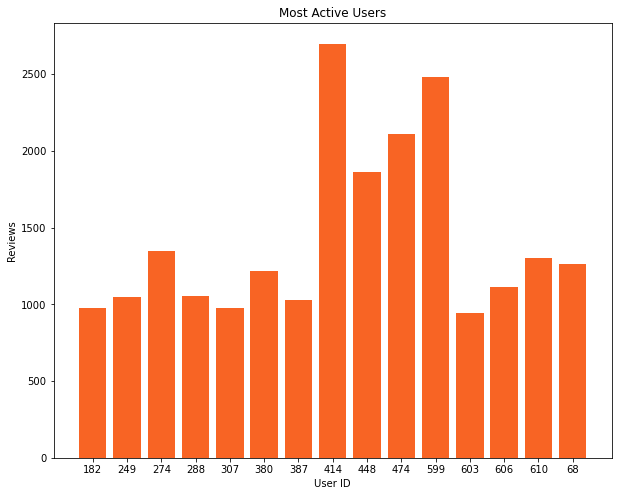

In [180]:
#additional code for graphing with matplot lib incase ploty does not work

#making user_id a string for graphing
top_15_reviewers['user_id'] = top_15_reviewers['user_id'].astype(str)
#making sorted df for chart
top_15_sorted = top_15_reviewers.sort_values('review_count')
#making airbnb_rating a string
grouped = top_15_sorted.groupby("user_id")["review_count"].sum()
fig = plt.figure(figsize = (10, 8))
# create a bar plot
plt.bar(grouped.index, grouped.values, color="#f86424")
# set the x-axis label
plt.xlabel("User ID")
# set the y-axis label
plt.ylabel("Reviews")
#adding title
plt.title("Most Active Users")
# show the plot
plt.show()

In [181]:
#making dataframe of rating counts to compare distribution of ratings
top_ratings = pd.DataFrame(movie_df["rating"].value_counts(ascending=False).head(15))
top_ratings = top_ratings.reset_index()
top_ratings = top_ratings.rename(columns={"rating":"rating_count"})
top_ratings = top_ratings.rename(columns={"index":"rating"})

#making user_id a string for plotting
top_ratings['rating'] = top_ratings['rating'].astype(str)

In [182]:
top_ratings

,rating,rating_count
0,4.0,26816
1,3.0,20044
2,5.0,13209
3,3.5,13134
4,4.5,8551
5,2.0,7550
6,2.5,5550
7,1.0,2811
8,1.5,1791
9,0.5,1367


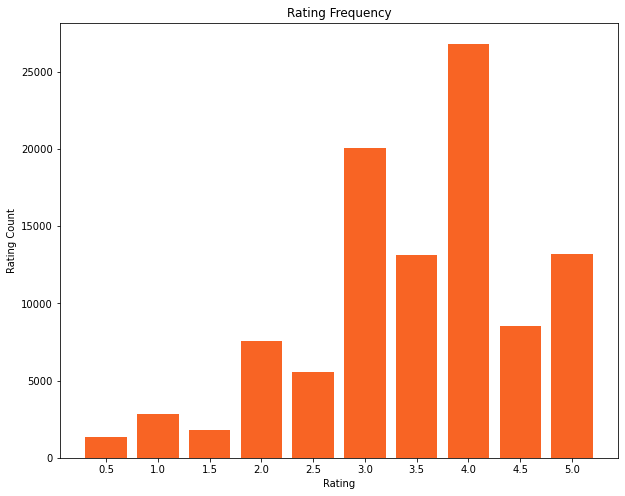

In [183]:
# additional code for graphing with matplot lib incase ploty does not work

#making bar graph of rating frequency
grouped = top_ratings.groupby("rating")["rating_count"].sum()
fig = plt.figure(figsize = (10, 8))
# create a bar plot
plt.bar(grouped.index, grouped.values, color="#f86424")
# set the x-axis label
plt.xlabel("Rating")
# set the y-axis label
plt.ylabel("Rating Count")
#adding title
plt.title("Rating Frequency")
# show the plot
plt.show()

In [184]:
#using plotly to plot the top reviewers
fig = px.bar(top_15_sorted, x="user_id", y="review_count")
fig.update_layout(title_text='Top Reviewers',
                  title_x=0.5,
                  xaxis_title="User Id",
                  yaxis_title="Review Count",
                 plot_bgcolor='white')
fig.update_traces(marker_color = "#f86424")
fig.show()

In [185]:
top_ratings.sort_values(by="rating")

,rating,rating_count
9,0.5,1367
7,1.0,2811
8,1.5,1791
5,2.0,7550
6,2.5,5550
1,3.0,20044
3,3.5,13134
0,4.0,26816
4,4.5,8551
2,5.0,13209


In [211]:
#using plotly to plot the top featurescolor=
fig = px.bar(top_ratings.sort_values(by="rating_count"), x="rating_count", y="rating")
fig.update_layout(title_text='Rating Frequency',
                  title_x=0.5,
                  xaxis_title="Rating Count",
                  yaxis_title="Rating",
                 plot_bgcolor='white',
                 font=dict(size=14))
fig.update_traces(marker_color = "#f86424")

fig.show()

# Data Modeling - Recommendation System
To create a personalized recommendation system for our dataset, we will use a method called **user-based collaborative filtering**. This approach is based on the idea that people who have similar tastes or preferences in the past will have similar tastes in the future. This means that the model makes recommendations based on other similar user preferences.

To apply user-based collaborative filtering, the model will identify the movies that the user has rated in the past. It will then find other users who have rated those movies similarly to the target user. Once similar users have been found, the model will use their ratings to predict the target user's rating for movies they have not yet seen.

**Root Mean Square Error (RMSE)** score will be used as the main metric to determine the accuracy of the predictive model. The RMSE measures the difference between the actual and prediting ratings. The movie ratings are on a scale of 1-5.

### Surprise Data
To make this model, we will be using the python package Surprise. This is a scikit tool that uses a range of algorithms made up of matrix factorization-based methods for collaborative filtering. 

To begin, we will make new dataframe from our final cleaned dataframe with three columns that include user **id, ratings, and movie ids.**

In [45]:
#dropping columns that aren't needed for Surprise (since )
surprise_df = movie_df.drop(columns=["title", "genre_1", "genre_2", "genre_3", "genre_4",
                                    "genre_5", "tmdbId", "year"])

In [46]:
#checking final dataframe
surprise_df

,user_id,movie_id,rating
0,1,1,4.0
1,1,3,4.0
2,1,6,4.0
3,1,47,5.0
4,1,50,5.0
...,...,...,...
100831,610,166534,4.0
100832,610,168248,5.0
100833,610,168250,5.0
100834,610,168252,5.0


In [47]:
surprise_df['user_id'].value_counts()

414    2698
599    2478
474    2108
448    1863
274    1346
       ... 
406      20
595      20
569      20
431      20
442      20
Name: user_id, Length: 610, dtype: int64

### Surprise Data and Train Test Split

In [48]:
from surprise import Reader, Dataset

reader = Reader(rating_scale=(1, 5))

#loading final dataset
data = Dataset.load_from_df(surprise_df, reader)

#spltting into train and test
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [49]:
#looking at number of users
print('Number of users: ', trainset.n_users, '\n')
print('Number of items: ', trainset.n_items)

Number of users:  610 

Number of items:  8951


## Baseline Model

In [196]:
# Instantiate the model
baseline = NormalPredictor()

#fitting model
baseline.fit(trainset)

# making prediction on testset
predictions = baseline.test(testset)

# Save RMSE score
baseline_normal = accuracy.rmse(predictions)

RMSE: 1.4310


In [58]:
#saving normal rmse
test_baseline_normal_rmse = 1.4310

The Normal Predictor baseline model's Root Mean Squared Error (RMSE) tells us that our predicted rating is **1.43** points away from the actual rating.

In [197]:
# Instantiate and fit model
baseline2 = BaselineOnly()

#fitting model
baseline2.fit(trainset)

# making prediction on testset
predictions = baseline2.test(testset)

# Save RMSE score
baseline_only = accuracy.rmse(predictions)

Estimating biases using als...
RMSE: 0.8725


In [57]:
#saving baseline rmse for final graph
test_baseline_only_rmse = 0.8725

The Baseline Only model's Root Mean Squared Error (RMSE) tells us that our predicted rating is **.875** points away from the actual rating. This is an improvement from the first model.

## Model #1 - SVD

We will be using Singular Value Decomposition (SVD) to reduce the dimensionality of our matrix. SVD is a matrix factorization model that decomposes the reviewer reviews and movies into three matrices. This helps us understand the relationship between users and items.

In [202]:
# Cross validate a basic SVD with no hyperparameter tuning expecting sub-par results
svd_basic = SVD(random_state=42)

results = cross_validate(svd_basic, data, measures=['RMSE'], cv=3, n_jobs = -1, verbose=True)

Evaluating RMSE of algorithm SVD on 3 split(s).

                  Fold 1  Fold 2  Fold 3  Mean    Std     
RMSE (testset)    0.8783  0.8784  0.8811  0.8793  0.0013  
Fit time          3.14    3.11    3.16    3.14    0.02    
Test time         0.16    0.16    0.16    0.16    0.00    


In [203]:
# Fit to trainset and predict on the testset for evaluation
svd_basic.fit(trainset)

predictions = svd_basic.test(testset)

svd_simple = accuracy.rmse(predictions)

RMSE: 0.8734


In [60]:
#saving simmple rmse for final graph
test_svd_simple_rmse = 0.8734

The SVD performed worse than the base model. Further tuning of the hyperparameters will need to be made.

## SVD Grid Search

With a SVD Grid Search, we will adjust the following hyperparameters:

- **n_factors:** Increasing the number of n_factors (latent features) will make the model more complex and could help with performance on the testing data. A number that is too high, could result in overfitting. 

- **n_epochs:** This adjusts the number of iterations that are run on the data. A value that is too low will underfit the model, while a value that is too high could result in overfitting. Since this is a large dataset, we will most likely end up with a higher number.

- **init_mean:** The mean of the normal distribution for factor vectors (include latent factors that represent user preferences) initialization

- **reg_all** This controls how much the model penalizes larger parameter values. This helps prevent overfitting.

- **biased** User bias is common when making reviews, as users tend to either favor high or low ratings. Adjusting this could help with the accuracy of the model, if the reviews for each user seem to be biased.

### Grid Search #1

In [208]:
#test grid search
params = {'n_factors': [10, 50, 100, 150, 200],
          'n_epochs': [10, 20],
          'init_mean': [-0.5, 0.5], 
          'reg_all': [.05, 0.02],
         'biased': [True, False]}

g_s_svd = GridSearchCV(SVD, param_grid=params, cv=5, refit=True)

g_s_svd.fit(data)
g_s_svd.best_params['rmse']

{'n_factors': 10,
 'n_epochs': 20,
 'init_mean': 0.5,
 'reg_all': 0.02,
 'biased': False}

In [210]:
print(g_s_svd.best_score)
print(g_s_svd.best_params)

{'rmse': 0.8808879468723733, 'mae': 0.6758993339989241}
{'rmse': {'n_factors': 10, 'n_epochs': 20, 'init_mean': 0.5, 'reg_all': 0.02, 'biased': False}, 'mae': {'n_factors': 10, 'n_epochs': 20, 'init_mean': -0.5, 'reg_all': 0.01, 'biased': False}}


In [271]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd = SVD(n_factors=10,n_epochs=20, init_mean=0.5, reg_all=0.02, biased=False)

# fit on trainset and make predictions using testset
g_s_svd.fit(trainset)
predictions = g_s_svd.test(testset)
g_s_svd_1 = accuracy.rmse(predictions)

RMSE: 0.8771


In [50]:
#saving test rmse for final graph
test_g_s_svd_1_params = {'n_factors': 10,'n_epochs': 20,'init_mean': 0.5,'reg_all': 0.02, 'biased': False}
test_g_s_svd_1_rmse = 0.8771

## Grid Search #2

Performing another grid search lowering the reg_all and increasing n_factors

In [215]:
#test grid search
params_2 = {'n_factors': [5, 10, 50, 100],
         'n_epochs': [10, 20, 30],
             'init_mean': [0, 0.5],
            'reg_all': [.005, .01, 0.02, .005],
           'biased': [True, False]}

g_s_svd_2 = GridSearchCV(SVD, param_grid=params_2, cv=3, refit=True)

g_s_svd_2.fit(data)
g_s_svd_2.best_params['rmse']

{'n_factors': 10,
 'n_epochs': 10,
 'init_mean': 0.5,
 'reg_all': 0.01,
 'biased': False}

In [223]:
print(g_s_svd_2.best_score)
print(g_s_svd_2.best_params)

{'rmse': 0.8840175621942711, 'mae': 0.6787384404177316}
{'rmse': {'n_factors': 10, 'n_epochs': 10, 'init_mean': 0.5, 'reg_all': 0.01, 'biased': False}, 'mae': {'n_factors': 10, 'n_epochs': 10, 'init_mean': 0.5, 'reg_all': 0.01, 'biased': False}}


In [272]:
#saving best params
grid_2_best_params = g_s_svd_2.best_params['rmse']

In [273]:
grid_2_best_params

{'n_factors': 10,
 'n_epochs': 10,
 'init_mean': 0.5,
 'reg_all': 0.01,
 'biased': False}

In [275]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd_2 = SVD(n_factors=10, n_epochs=10, init_mean=0.5, reg_all=0.01, biased=False)

# fit on trainset and make predictions using testset
g_s_svd_2.fit(trainset)
predictions = g_s_svd_2.test(testset)
g_s_svd_2_rmse = accuracy.rmse(predictions)

RMSE: 0.8791


In [51]:
#saving test rmse
test_g_s_svd_2_params = {'n_factors': 10, 'n_epochs': 10, 'init_mean': 0.5, 'reg_all': 0.01, 'biased': False}
test_g_s_svd_2_rmse = 0.8791

### Grid Search #3

Performing another grid search to remove "biased" since this was false and "reg_all" to reduce complexity of search and save computation time.

In [525]:
#test grid search
params_3 = {'n_factors': [50, 100, 200],
          'reg_all': [0.02, .05],
         'n_epochs': [10, 20, 30]}


g_s_svd_3 = GridSearchCV(SVD, param_grid=params_3, cv=5, refit=True)

g_s_svd_3.fit(data)
print(g_s_svd_3.best_params['rmse'])

{'n_factors': 100, 'reg_all': 0.05, 'n_epochs': 30}


In [528]:
print(g_s_svd_3.best_score['rmse'])

0.8623815254788681


In [526]:
#saving best params
g_s_svd_3_best_params = {'n_factors': 100, 'reg_all': 0.05, 'n_epochs': 30}

In [529]:
# instantiating SVD with best hyperparameters from gridsearch
g_s_svd_3 = SVD(n_factors=100, n_epochs=30, reg_all=0.05)

# fit on trainset and make predictions using testset
g_s_svd_3.fit(trainset)
predictions = g_s_svd_3.test(testset)
g_s_svd_3_rmse = accuracy.rmse(predictions)

RMSE: 0.8630


In [52]:
#saving test rmse and params for final graph
test_g_s_svd_3_params = {'n_factors': 100, 'reg_all': 0.05, 'n_epochs': 30}
test_g_s_svd_3_rmse = 0.8630

### Grid Search #4

In this search I increased the values for n_factors, and n_epochs to increase complexity of model since the last grid searched favored higher values. This improved the overall RMSE value slighty, so we will try out another model type to see if this can be further improved.

In [515]:
#test grid search
params_4 = {'n_factors': [400, 500, 600],
          'reg_all': [0.02, .05],
           'n_epochs': [70, 80, 90]}

g_s_svd_4 = GridSearchCV(SVD, param_grid=params_6, cv=3, refit=True)

g_s_svd_4.fit(data)
g_s_svd_4.best_params['rmse']

{'n_factors': 400, 'reg_all': 0.05, 'n_epochs': 90}

In [516]:
print(g_s_svd_4.best_score['rmse'])

0.8621651917446677


In [517]:
#saving params and rmse score
best_model_rmse = 0.8621651917446677
best_model_params = {'n_factors': 400, 'reg_all': 0.05, 'n_epochs': 90}

In [518]:
# instantiating SVD from grid search params
svd_best_model = SVD(n_factors=400, reg_all=0.05, n_epochs=90)

# fit on trainset and make predictions using testset
svd_best_model.fit(trainset)
predictions = svd_best_model.test(testset)
svd_gs_best = accuracy.rmse(predictions)

RMSE: 0.8545


In [53]:
#saving test rmse
test_svd_gs_best_params = {'n_factors': 400, 'reg_all': 0.05, 'n_epochs': 90}
test_svd_gs_best_rmse = 0.8545

### Non-Negative Matrix Factorization (NMF) Grid Search

We will switch up our technique to use a neural-network based model, Non-Negative Matrix Factorization (NFM). This is similar to SVD, but is more complex andcaptures non-linear feature interactions (interactions between features that are hard to predict) better.

In [423]:
# New hyperparameter dictionary for nmf model
nmf_param_grid = {'biased':[True, False],
                  'n_factors':[100, 500],
                  'n_epochs': [20, 25, 50]}
nmf_gs_model = GridSearchCV(NMF, param_grid=nmf_param_grid, cv=3, joblib_verbose=10, return_train_measures=True)

# Fit and return the best hyperparameters
nmf_gs_model.fit(data)
nmf_gs_model.best_params['rmse']

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.8s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   17.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:   24.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:   31.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:   37.4s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:   49.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  1.0min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  1.3min remaining:    0.0s
[Parallel(n_jobs=1)]: Done  36 out of  36 | elapsed: 15.9min finished


{'biased': False, 'n_factors': 100, 'n_epochs': 50}

In [530]:
nmf_gs_model.best_score['rmse']

1.0316376118114208

In [531]:
#saving params and best rmse
nmf_gs_model_rmse = 1.0316376118114208
nmf_gs_model_best_params = {'biased': False, 'n_factors': 100, 'n_epochs': 50}

In [425]:
# instantiating NFM
nfm_model = NMF(biased=False, n_factors=100, n_epochs=50)

# Fit on trainset and make predictions using testset to return RMSE metric
nfm_model.fit(trainset)
predictions = nfm_model.test(testset)
nfm_model_1 = accuracy.rmse(predictions)

RMSE: 1.0341


In [54]:
#saving test nfm model rmse for final graph
test_nfm_model_1_params = {'biased': False, 'n_factors': 100, 'n_epochs': 50}
test_nfm_model_1_rmse = 1.0341

# Results

#### Best Model

We used Singular Value Decomposition (SVD) to create our final model. This is a collaborative filtering method that identifies relationship between users movie ratings to make personzlied recommendations for users, based on their previous ratings.

Our best model was the final SVD Grid Search that gave us a **RMSE of .85**. 

- n_factors = 400
- reg_all = .05
- n_epochs = 90

#### Best Model

In [55]:
# instantiating SVD from grid search params
svd_best_model = SVD(n_factors=400, reg_all=0.05, n_epochs=90)

# fit on trainset and make predictions using testset
svd_best_model.fit(trainset)
predictions = svd_best_model.test(testset)
svd_gs_best = accuracy.rmse(predictions)

RMSE: 0.8539


In [61]:
#making dataframe of all RMSE scores for all models

model_name = ["Baseline Only", "SVD Basic", "SVD GS1", "SVD GS2", "SVD GS3", "SVD Best Model"]
rmse_score_model = [test_baseline_only_rmse, test_svd_simple_rmse,
                    test_g_s_svd_1_rmse, test_g_s_svd_2_rmse, test_g_s_svd_3_rmse, test_svd_gs_best_rmse]

model_df = pd.DataFrame()
model_df['RMSE'] = rmse_score_model
model_df['Model'] = model_name
model_df = model_df.sort_values(by="RMSE")

In [62]:
model_df

,RMSE,Model
5,0.8545,SVD Best Model
4,0.8630,SVD GS3
0,0.8725,Baseline Only
1,0.8734,SVD Basic
2,0.8771,SVD GS1
3,0.8791,SVD GS2


In [66]:
model_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6 entries, 5 to 3
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   RMSE    6 non-null      float64
 1   Model   6 non-null      object 
dtypes: float64(1), object(1)
memory usage: 144.0+ bytes


In [263]:
import plotly.express as px
import plotly.io as pio

x = model_df['Model']
y = model_df['RMSE']

#using plotly to plot the model RMSE scores
fig = px.bar(model_df, x=x, y=y, text=y, text_auto='.2')

# marker color for all bars
colors = ['#f86424'] * len(x)

#changing color of best model
colors[0] = '#24b8f8'

fig.update_layout(
    plot_bgcolor='white',
    title_text='Surprise Model Comparison',
    title_x=0.5,
    xaxis_title="Model",
    yaxis_title="RMSE",
    yaxis=dict(
        tick0=0.8,
        dtick=0.01,
        tickformat='.2f',
        range=[0.83, max(y)*1.01]
    )
)

fig.update_traces(marker_color=colors, textposition="outside")

fig.show()

## Build Function

Below we will be building a function called "ind_recommend_movies()" which will take in a user ID and return a specific number of reccommended movies based on the predicted rating the user would give. This function is built of of our best model from above XXXX. The code for this function has been adapted from Daniel Burdenos 
<a href="https://github.com/danielburdeno/Kindle-eBook-Recommendations/blob/bb3c8016c0817f78c9143c1b218366d7cbb9b588/CollaborativeFiltering.ipynb">Capstone Project </a>.
To beging this function I will be creating a new "user" dataframe for ease of use and adding a new column to the movie_df called "average_rating"
   
   - user_df: this dataframe only contains the user_id and movie_id with the user_id being the index

In [71]:
#saving new dataframe with only user information
user_df = surprise_df.reset_index()
user_df.set_index('user_id', inplace = True)
user_df.drop(columns = 'rating', inplace =True)
user_df.head()

,index,movie_id
user_id,,
1,0,1
1,1,3
1,2,6
1,3,47
1,4,50


Below we are defining the function:

In [272]:
def ind_recommend_movies():
    
    user = int(input('user_id: '))
    n_recs = int(input('How many movie recommendations do you want? '))
    
    have_rated = list(user_df.loc[user, 'movie_id'])
    not_rated = movie_df.copy()
    not_rated.drop(have_rated, inplace=True)
    not_rated = not_rated.drop_duplicates(subset=['movie_id'])
    not_rated.reset_index(inplace = True)
    not_rated['est_rating'] = not_rated['movie_id'].apply(lambda x: svd_best_model.predict(user, x).est)
    not_rated.sort_values(by = 'est_rating', ascending = False, inplace = True)
    not_rated = not_rated.rename(columns={'movie_id':'Movie',
                               'genre_1':'Genre','genre_2':'Genre', 'genre_3':'Genre',
                                           'genre_4':'Genre', 'genre_5':'Genre', 
                                         'title':'Title', 'est_rating':'Predicted Rating'})
    not_rated = not_rated.drop(columns=["tmdbId", 'rating', 'index', 'user_id'])
    return not_rated.head(n_recs)

In [273]:
ind_recommend_movies()

user_id: 1
How many movie recommendations do you want? 3


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
5048,3200,Comedy,Drama,0,0,0,1973,"Last Detail, The",5.0
2070,1262,Action,Adventure,Drama,War,0,1963,"Great Escape, The",5.0
1319,168252,Action,Sci-Fi,0,0,0,2017,Logan,5.0


In [255]:
# #testing function is running appropriately by hardcoding a user ID

# user = 450
# have_rated = list(user_df.loc[user, 'movie_id'])
# not_rated = movie_df[~movie_df['movie_id'].isin(have_rated)] #saving new df where have_rated is removed
# not_rated = not_rated.reset_index()
# not_rated['est_rating'] = not_rated['movie_id'].apply(lambda x: svd_best_model.predict(user, x).est)
# not_rated = not_rated.drop_duplicates(subset=['movie_id']) #drop before in different df
# not_rated.sort_values(by='est_rating', ascending=False, inplace=True)
# not_rated.head(5)

Looks like our model is running well! Lets show a few different users and compare their recommended movies! We can look at what they rated highly in the past to see if their new expeted high ratings and reccomendations make sense with what we know they rated high.

### Recommendation - Function Testing

#### User Test #1 - User ID 1

In [274]:
#user ID 1
ind_recommend_movies()

user_id: 1
How many movie recommendations do you want? 3


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
5048,3200,Comedy,Drama,0,0,0,1973,"Last Detail, The",5.0
2070,1262,Action,Adventure,Drama,War,0,1963,"Great Escape, The",5.0
1319,168252,Action,Sci-Fi,0,0,0,2017,Logan,5.0


In [287]:
#highest rated movies User ID 1
user1 = movie_df.loc[movie_df['user_id'] == 1].sort_values(by = 'rating', ascending = False).head(3)
user1.drop(columns = ['tmdbId','user_id'] )

,movie_id,rating,genre_1,genre_2,genre_3,genre_4,genre_5,year,title
231,5060,5.0,Comedy,Drama,War,0,0,1970,M*A*S*H (a.k.a. MASH)
185,2872,5.0,Adventure,Fantasy,0,0,0,1981,Excalibur
89,1291,5.0,Action,Adventure,0,0,0,1989,Indiana Jones and the Last Crusade


Based on the above we can see that the highest rated movie that use 1 liked was 3 genres and of Adventure, Drama and War. Our model predicted that the highest rated movie this user would like would also be 3 genres 2 of which would be Drama and War. Pretty cool! Lets see some other users and see how it does. 

#### User Test #2 - User ID 450

In [276]:
#User ID 450
ind_recommend_movies()

user_id: 450
How many movie recommendations do you want? 3


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
2381,1204,Adventure,Drama,War,0,0,1962,Lawrence of Arabia,4.886559
15,260,Action,Adventure,Sci-Fi,0,0,1977,Star Wars: Episode IV - A New Hope,4.835288
1019,858,Crime,Drama,0,0,0,1972,"Godfather, The",4.834502


In [286]:
#highest rated movies User ID 450
user450 = movie_df.loc[movie_df['user_id'] == 450].sort_values(by = 'rating', ascending = False).head(3)
user450.drop(columns = ['tmdbId','user_id'] )

,movie_id,rating,genre_1,genre_2,genre_3,genre_4,genre_5,year,title
70576,1673,5.0,Drama,0,0,0,0,1997,Boogie Nights
70569,1193,5.0,Drama,0,0,0,0,1975,One Flew Over the Cuckoo's Nest
70606,3972,5.0,Action,Comedy,0,0,0,1994,"Legend of Drunken Master, The (Jui kuen II)"


Interesting to note here the top three movies recommended for user 450 center around the same years created as the top 3 he/she actually rated! Makes snese that the ones recommended are Action and Drama focused based on the ones truly rated. Lets test one more user to see how the recommendation system works here.

#### User Test #3 - User ID 312

Below we are testing on User 312 since this user had a more diverse rating so the model could be more interesting in predicting for him/her. 

In [278]:
#can see below that the user has a pretty even split between rating 4, 4.5 and 5
user601 = movie_df.loc[movie_df['user_id'] == 312].sort_values(by = 'rating', ascending = False)
user601['rating'].value_counts()

4.0    103
3.0     68
5.0     37
2.0     11
1.0      4
Name: rating, dtype: int64

In [279]:
#User ID 312
ind_recommend_movies()

user_id: 312
How many movie recommendations do you want? 3


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
702,924,Adventure,Drama,Sci-Fi,0,0,1968,2001: A Space Odyssey,4.899981
1041,541,Action,Sci-Fi,Thriller,0,0,1982,Blade Runner,4.838750
4233,1178,Drama,War,0,0,0,1957,Paths of Glory,4.807745


In [280]:
user312 = movie_df.loc[movie_df['user_id'] == 312].sort_values(by = 'rating', ascending = False).head(3)
user312.drop(columns = ['tmdbId','user_id'] )

,movie_id,rating,genre_1,genre_2,genre_3,genre_4,genre_5,year,title
48066,1196,5.0,Action,Adventure,Sci-Fi,0,0,1980,Star Wars: Episode V - The Empire Strikes Back
48038,527,5.0,Drama,War,0,0,0,1993,Schindler's List
48086,1289,5.0,Documentary,0,0,0,0,1983,Koyaanisqatsi (a.k.a. Koyaanisqatsi: Life Out ...


Once again our model proves highly accurate in predicting Genres and Movies the user would like! The top 3 rated by user 601 was Action, Adventure, and Action and these are the three spit out by out model too. The movie titles themselves seem accurate in what you would expect to be recommended bases on the movies rated. 

### Creating function to including option for filtering on Genre for recommendations

Through this function a user can now input which genre he/she would like to watch in addition to how many movies he/she would like recommended. 

In [281]:
#adding in fliltering for genre
def recommend_movies_w_genre():
    
    user = int(input('user_id: '))
    n_recs = int(input('How many movie recommendations do you want? '))
    genre = input('What genre do you want to watch? ')
    
    have_rated = list(user_df.loc[user, 'movie_id'])
    not_rated = movie_df.copy()
    not_rated.drop(have_rated, inplace=True)
    not_rated = not_rated.loc[(not_rated['genre_1'] == genre) | (not_rated['genre_2'] == genre) |
             (not_rated['genre_3'] == genre) | (not_rated['genre_4'] == genre)
                             | (not_rated['genre_5'] == genre)]
    not_rated = not_rated.drop_duplicates(subset=['movie_id'])
    not_rated.reset_index(inplace = True)
    not_rated['est_rating'] = not_rated['movie_id'].apply(lambda x: svd_best_model.predict(user, x).est)
    not_rated.sort_values(by = 'est_rating', ascending = False, inplace = True)
    not_rated = not_rated.rename(columns={'movie_id':'Movie',
                               'genre_1':'Genre','genre_2':'Genre', 'genre_3':'Genre',
                                           'genre_4':'Genre', 'genre_5':'Genre', 
                                         'title':'Title', 'est_rating':'Predicted Rating'})
    not_rated = not_rated.drop(columns=["tmdbId", 'rating', 'index', 'user_id'])
    return not_rated.head(n_recs)

#### User 1 with recommended Drama movies:

In [282]:
recommend_movies_w_genre()

user_id: 1
How many movie recommendations do you want? 3
What genre do you want to watch? Drama


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
814,3451,Drama,0,0,0,0,1967,Guess Who's Coming to Dinner,5.0
128,1250,Adventure,Drama,War,0,0,1957,"Bridge on the River Kwai, The",5.0
1424,3201,Drama,0,0,0,0,1970,Five Easy Pieces,5.0


Comparison to Drama movies rated by user 1

In [283]:
user1_genre = movie_df.loc[(movie_df['user_id'] == 1) & ((movie_df['genre_1'] == 'Drama') 
                                                             | (movie_df['genre_2'] == 'Drama') | (movie_df['genre_3'] == 'Drama') | 
                                                             (movie_df['genre_4'] == 'Drama') | (movie_df['genre_5'] == 'Drama'))].sort_values(by = 'rating', ascending = False).head(3)
user1_genre.drop(columns = ['tmdbId','user_id'] )

,movie_id,rating,genre_1,genre_2,genre_3,genre_4,genre_5,year,title
115,1954,5.0,Drama,0,0,0,0,1976,Rocky
100,1573,5.0,Action,Crime,Drama,Thriller,0,1997,Face/Off
111,1804,5.0,Crime,Drama,0,0,0,1998,"Newton Boys, The"


#### User 450 with recommended Thriller movies:

In [284]:
recommend_movies_w_genre()

user_id: 450
How many movie recommendations do you want? 3
What genre do you want to watch? Thriller


,Movie,Genre,Genre,Genre,Genre,Genre,year,Title,Predicted Rating
80,2186,Crime,Drama,Film-Noir,Thriller,0,1951,Strangers on a Train,4.746374
276,6440,Drama,Thriller,0,0,0,1991,Barton Fink,4.746032
244,1252,Crime,Film-Noir,Mystery,Thriller,0,1974,Chinatown,4.725789


Comparison to Thriller movies rated by user 450

In [285]:
user450_genre = movie_df.loc[(movie_df['user_id'] == 450) & ((movie_df['genre_1'] == 'Thriller') 
                                                             | (movie_df['genre_2'] == 'Thriller') | (movie_df['genre_3'] == 'Thriller') | 
                                                             (movie_df['genre_4'] == 'Thriller') | (movie_df['genre_5'] == 'Thriller'))].sort_values(by = 'rating', ascending = False).head(3)
user450_genre.drop(columns = ['tmdbId','user_id'] )

,movie_id,rating,genre_1,genre_2,genre_3,genre_4,genre_5,year,title
70570,1206,5.0,Crime,Drama,Sci-Fi,Thriller,0,1971,"Clockwork Orange, A"
70591,3510,5.0,Drama,Thriller,0,0,0,2000,Frequency
70559,111,4.0,Crime,Drama,Thriller,0,0,1976,Taxi Driver


Filtering by genre is just the beginning! With more information for the movie we could filter on even more, next ideas that would be interesting would likely be a language filter, director, production studio and items like this. 

# Conclusions and Next Steps

Our recommendation model aims to simplify the movie selection process for individuals by providing personalized movie suggestions based on their viewing history and preferences. By predicting expected ratings for movies that users have yet to rate, we hope to encourage more accurate ratings, which will result in even better recommendations.

To enhance the predicted ratings and improve the overall user experience, we're exploring several directions for further development. These include:

1. Run more grid searches and use different model types to improve the RMSE for the best predictions
2. Add in a additional options to our function to allow the user to get recommended movies for a specific characteristics of a movie as opposed to just the top expected rating movie across any category. For example, as mentioned above perhaps an option for selecting director, production studio, language, year created and others. 
3. Look further into a content based filtering in addition to our collaborative model. 
4. Deploy an app that utizes the recommendation model

Thank you!

For further information please reach out to:
- Anat Jacobson: <a href="https://github.com/anat-jacobson"> Github Profile </a>.
- Stephanie Ciaccia: <a href="https://github.com/stephcia "> Github Profile </a>.